In [238]:
#import csv
#this part was done on Google Colab
!gdown --id 1L5o2fVXibffuzWepsKljbO8KfEgdixjY
!gdown --id 11LL7r7YePq_lpa_14z4DDb68TVRM0E2w

Downloading...
From: https://drive.google.com/uc?id=1L5o2fVXibffuzWepsKljbO8KfEgdixjY
To: /content/Fake.csv
62.8MB [00:00, 172MB/s] 
Downloading...
From: https://drive.google.com/uc?id=11LL7r7YePq_lpa_14z4DDb68TVRM0E2w
To: /content/True.csv
53.6MB [00:00, 202MB/s]


# Library and Data Import

In [239]:
# Library Import

import gensim
import keras
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub


from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
from keras.layers import Input, GlobalMaxPooling1D, LSTM
from keras.layers import Conv1D, MaxPooling1D,Activation, Flatten

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [240]:
# Data Load
real_news = pd.read_csv('True.csv')
fake_news = pd.read_csv('Fake.csv')

In [241]:
real_news.shape, fake_news.shape

((21417, 4), (23481, 4))

Here we noted that there are more than 20k real news articles and fake news articles.
<br>
It could be considered as a rather balanced dataset.

In [242]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


# Data Pre-processing

In [243]:
# assign the label of fakes news to the dataset
# 'is_fake'= 1 for fake news articles and ‘is_fake' =0 for real news articles

real_news['is_fake'] = 0
fake_news['is_fake'] = 1

# Hence we concat these two dataframes
all_news = real_news.append(fake_news,  ignore_index=True)

The Kaggle Blog over here points out the problem of data leakage in this dataset.
https://www.kaggle.com/mosewintner/5-data-leaks-100-acc-1-word-99-6-acc/comments (for more details)
<br>
The problems inlcude the presence of the string (Reuters)in text column,the distribution of subject and the date itself and URLs in date column. 
<br>
In order to have a more fair dataset setting, here in this dataset we would drop the subject and date column as well as removing the word (Reuters) in the text.

In [244]:
# Drop the column of subject and date as per the reason stated above
all_news = all_news.drop(columns=['subject', 'date'])

#Also, we want to remove the presence of string '(Reuters)'
all_news['text'] = all_news['text'].str.replace('\(Reuters\)', '')


In [245]:
all_news.shape

(44898, 3)

Here we propose to have 3 different models for this binary text-classfication:
<br>
1. TF-iDF processing + LightGBM
2. word2vec processing + CNN
3. word2vec processing + CNN LSTM

In [246]:
#Define a function to conduct common word-preprocessing operations (e.g. lowercase, remove stopwords and remove punctuationetc.)
#Convert X to format accepatable to further processing
#This function is referenced from https://www.kaggle.com/rahulkumarpatro/fake-vs-real-news-classification-lstm-word2vec

def get_cleaned_data(input_data, mode='df'):
    stop = stopwords.words('english')
    
    input_df = ''
    
    if mode != 'df':
        input_df = pd.DataFrame([input_data], columns=['text'])
    else:
        input_df = input_data       
    #lowercase the text
    input_df['text'] = input_df['text'].str.lower()    
    #remove special characters
    input_df['text'] = input_df['text'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))    
    # remove numbers
    input_df['text'] = input_df['text'].apply(lambda elem: re.sub(r"\d+", "", elem))    
    #remove stopwords
    input_df['text'] = input_df['text'].apply(lambda x: ' '.join([word.strip() for word in x.split() if word not in (stop)]))
    
    input_df['text'] = input_df['text'].apply(lambda words: (wordnet_lemmatizer.lemmatize(words)))
    
    return input_df

In [247]:
all_news = get_cleaned_data(all_news)

In [248]:
all_news.head(3)

,title,text,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",washington head conservative republican factio...,0
1,U.S. military to accept transgender recruits o...,washington transgender people allowed first ti...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington special counsel investigation links...,0


# Model 1 (TF-iDF + LightGBM)

In [249]:
%%time
#create the tfidf-vectorizer
tfidf = TfidfVectorizer(strip_accents='ascii', ngram_range=(1,2), max_features=1000)

X_text = tfidf.fit_transform(all_news['text'])
y = all_news.is_fake

CPU times: user 53.2 s, sys: 1.55 s, total: 54.8 s
Wall time: 54.9 s


In [250]:
#Train-Test Split
train_x, test_x, train_y, test_y = train_test_split(X_text, y, test_size=.2, random_state=42)
#Train-validation Split  (train-70%, validation 10% and test 20%)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=.125, random_state=42)

In [251]:
%%time
# LightGBM parameter
parameters = {'num_leaves':20, 'max_depth':8,
              'objective':'binary', 'metric':'logloss',
              'learning_rate':0.05, 'n_jobs': -1,
              'n_estimators':100}

# LightGBM model
lgb_model = lgb.LGBMClassifier(**parameters)

lgb_model.fit(train_x, train_y, eval_set=[(val_x, val_y)],
             early_stopping_rounds=100, eval_metric='logloss', verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.115979
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.115979
CPU times: user 44.3 s, sys: 929 ms, total: 45.2 s
Wall time: 25.8 s


In [252]:
#Prediction
predict_lgb = lgb_model.predict(test_x)

In [253]:
print(classification_report(test_y, predict_lgb))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4330
           1       0.97      0.96      0.97      4650

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



# Model 2 (word2vec + CNN)

In [254]:
all_news.head()

,title,text,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",washington head conservative republican factio...,0
1,U.S. military to accept transgender recruits o...,washington transgender people allowed first ti...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington special counsel investigation links...,0
3,FBI Russia probe helped by Australian diplomat...,washington trump campaign adviser george papad...,0
4,Trump wants Postal Service to charge 'much mor...,seattlewashington president donald trump calle...,0


In [255]:
words = []

for i in all_news.text.values:
    words.append(i.split())

In [256]:
%%time
# To generate 200 Dimension of vectors 
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

CPU times: user 5min 12s, sys: 2.01 s, total: 5min 14s
Wall time: 3min 4s


In [257]:
len(w2v_model.wv.vocab)

202249

In [258]:
%%time
MAX_SEQUENCE_LENGTH = 500

tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = MAX_SEQUENCE_LENGTH)



# Embedding Layer creates one more vector for "UNKNOWN" words. 
# This Vector is filled with zeros.
# Thus the vocab size is increased by 1
vocab_size = len(tokenizer.word_index) + 1

# To create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

#Getting embedding vectors from word2vec and using the vectors as weights for later embedding 
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 18.3 s, sys: 594 ms, total: 18.9 s
Wall time: 19 s


In [259]:
#Set up the CNN
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(4))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(4))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 128 , activation = 'relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [260]:
cnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 500, 200)          40450000  
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 496, 128)          128128    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 124, 128)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 124, 128)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 120, 64)           41024     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 30, 64)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 64)          

In [261]:
y = all_news.is_fake

#Train-Test Split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=.2, random_state=42)
#Train-validation Split  (train-70%, validation 10% and test 20%)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=.125, random_state=42)

In [262]:
#Train the model 
%%time
cnn_model.fit(train_x, train_y, batch_size = 128 , validation_data = (val_x,val_y) , epochs = 2)

Epoch 1/2
246/246 [==============================] - 212s 860ms/step - loss: 0.4029 - accuracy: 0.8326 - val_loss: 0.0680 - val_accuracy: 0.9815
Epoch 2/2
246/246 [==============================] - 211s 857ms/step - loss: 0.0681 - accuracy: 0.9767 - val_loss: 0.0397 - val_accuracy: 0.9864
CPU times: user 13min 35s, sys: 4.98 s, total: 13min 40s
Wall time: 7min 3s


In [263]:
#Prediction
cnn_pred = (cnn_model.predict(test_x) > 0.5).astype("int")

print(classification_report(test_y, cnn_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4330
           1       0.98      0.99      0.99      4650

    accuracy                           0.99      8980
   macro avg       0.99      0.98      0.99      8980
weighted avg       0.99      0.99      0.99      8980



# Model 3 (word2vec + CNN LSTM)


In [270]:
#Set up the LSTM network
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
lstm_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
lstm_model.add(MaxPooling1D(4))
lstm_model.add(Dropout(0.1))
lstm_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
lstm_model.add(MaxPooling1D(4))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(units=64))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [271]:
lstm_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 500, 200)          40450000  
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 496, 128)          128128    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 124, 128)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 124, 128)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 120, 64)           41024     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 30, 64)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 64)          

In [272]:
#Train the model 
%%time
lstm_model.fit(train_x, train_y, batch_size = 128 , validation_data = (val_x,val_y) , epochs = 2)

Epoch 1/2
246/246 [==============================] - 222s 895ms/step - loss: 0.2764 - accuracy: 0.8759 - val_loss: 0.0546 - val_accuracy: 0.9817
Epoch 2/2
246/246 [==============================] - 218s 885ms/step - loss: 0.0422 - accuracy: 0.9860 - val_loss: 0.0290 - val_accuracy: 0.9920
CPU times: user 13min 59s, sys: 5.32 s, total: 14min 4s
Wall time: 7min 19s


In [273]:
lstm_pred = (lstm_model.predict(test_x) > 0.5).astype("int")

In [274]:
print(classification_report(test_y, lstm_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4330
           1       0.99      0.99      0.99      4650

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



# Summary

Here in this task, we have trained 3 classifcaiton models with two kinds of text processing setup:
<br>
1. TF-iDF processing + LightGBM
2. word2vec processing + CNN
3. word2vec processing + CNN LSTM

Rationale for model 1:
<br>
In model 1, we chose TF-iDF processing, which is a technique to quantify a word  in news by computing the weights with respect to the news and the corpus. It is a common method in Text Mining. After quantifying, we used LightGBM to process the classification task. LightGBM is a framework designed for fast training speed and high efficiency, hence the running time of model 1 is significantly faster than model 2 and model 3.

Rationale for model 2:
<br>
In this model, we used another text-processing setup, word2vec.  Word2vec is one kind of word-embedding which generates word vectors to capture semantic similarity, rather than just computing weight in TF-iDF. After processing, we used one type of  neural networks, CNN,to do the classification task. CNN usually works well on text and images.

Rationale for model 3:
<br>
The main addition element of model 3 is that LSTM  is being added. Therefore, the architecture of model 3 could be viewed as using CNN layer for feature extraction combined with LSTM to support the sequence prediction.


Result Summary (F1-score):
<br>
1. Model 1: 97%
2. Modle 2: 99%
3. Model 3: 99%

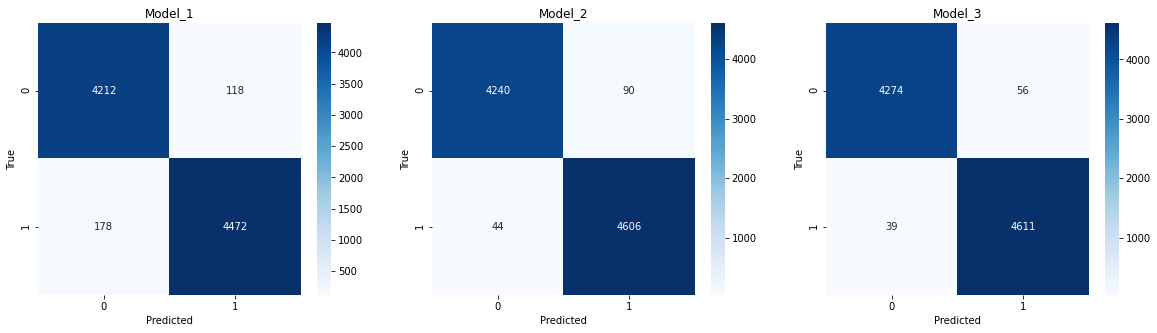

In [275]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.heatmap(confusion_matrix(test_y, predict_lgb), annot=True, cmap='Blues', fmt='g', ax=axes[0])
axes[0].set(xlabel='Predicted', ylabel='True', title ='Model_1')
sns.heatmap(confusion_matrix(test_y, cnn_pred), annot=True, cmap='Blues', fmt='g', ax=axes[1])
axes[1].set(xlabel='Predicted', ylabel='True', title ='Model_2')
sns.heatmap(confusion_matrix(test_y, lstm_pred), annot=True, cmap='Blues', fmt='g', ax=axes[2])
axes[2].set(xlabel='Predicted', ylabel='True', title ='Model_3')

plt.show()

We could see that all 3 models perform well with this task. 
<br>
In terms of training time, model 1 (TF-iDF processing + LightGBM) is the fastest one.
<br>
Meanwhile, the test result from Model 2 and Model 3 is  better than that from Model 1.

<br>
Therefore, if timing is a concern, model 1 could be the best option among these 3 models.
<br>
If we want to put more focus on semantic similarity as well as sequence, model 3 would be the best suitable one for further refinement.